In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import sys
import json
from numpy import linalg as LA

import tensorflow as tf

import getpass
ui = getpass.getuser()
if ui == 'laura':
    p = '/home/laura'
elif ui == 'lauradriscoll':
    p = '/Users/lauradriscoll/Documents'

net = 'stepnet'
PATH_YANGNET = os.path.join(p,'code/multitask-nets',net) 

sys.path.insert(0, PATH_YANGNET)
from task import generate_trials, rule_name, rule_index_map, rules_dict
from network import Model, get_perf, FixedPoint_Model
import tools
from analysis import clustering, standard_analysis, variance
import numpy.random as npr
from tools_lnd import make_h_all, PC_axes, proximate_fp, calc_jacobian_at, get_model_params
from tools_lnd import make_dendro, gen_trials_from_model_dir, gen_X_from_model_dir, get_T_inds
from sklearn.decomposition import PCA
from sklearn import linear_model
from numpy import linalg as LA
from tools_lnd import get_D, make_h_trial_rule, get_model_params, plot_N

figpath = os.path.join(p,'code','overleaf','multitask-nets','v2_figs','transfer')
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [2]:
def remove_spines(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

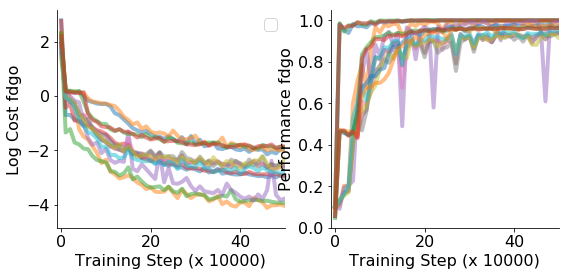

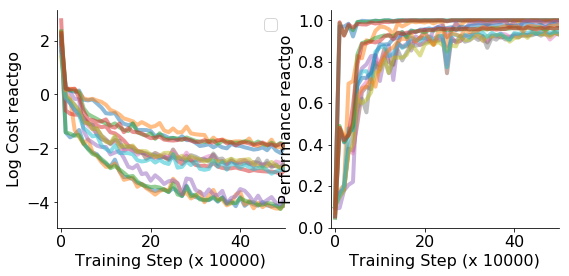

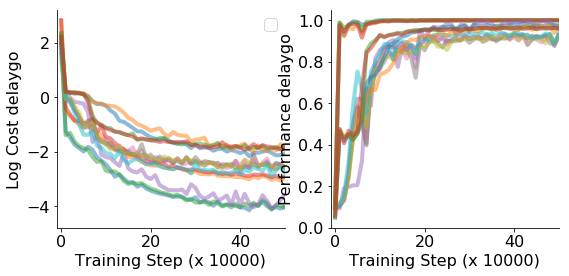

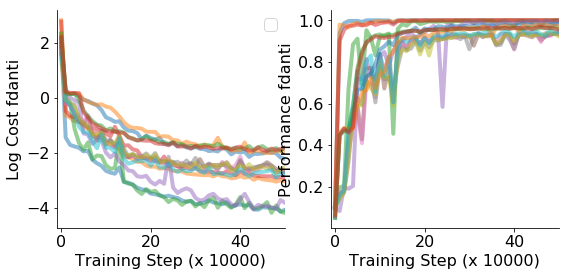

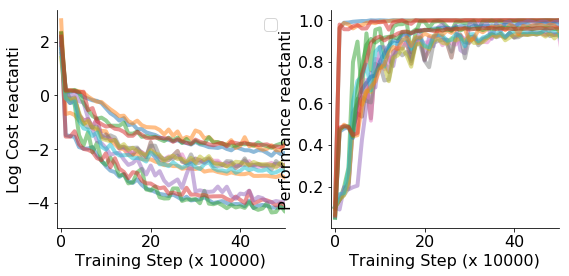

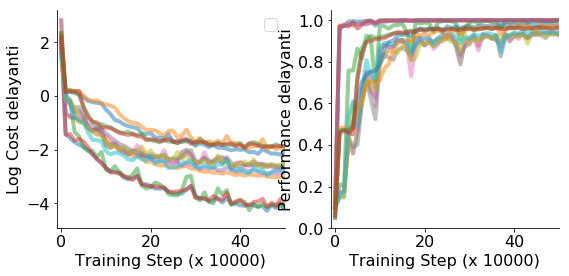

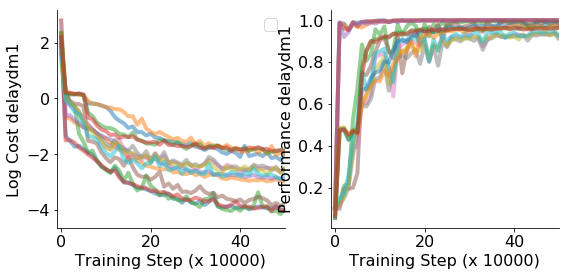

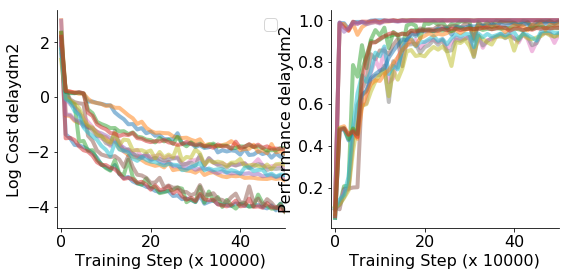

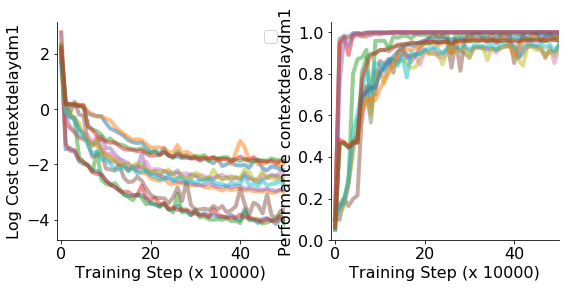

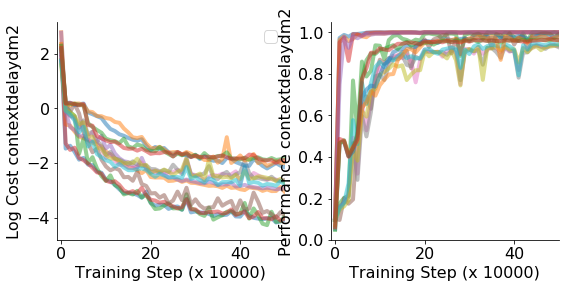

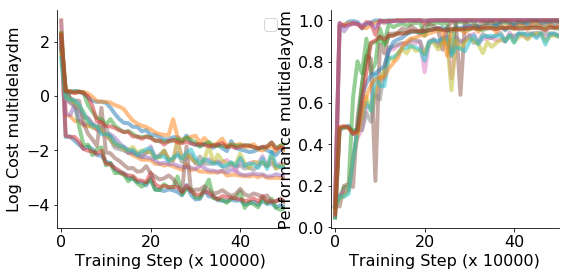

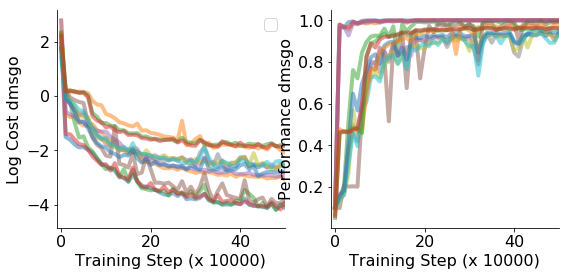

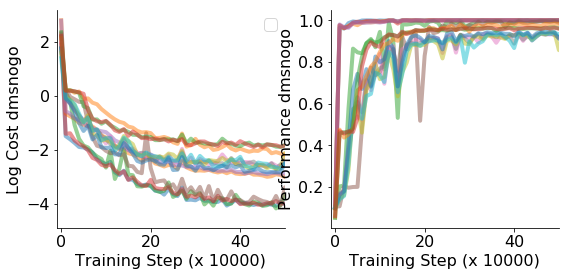

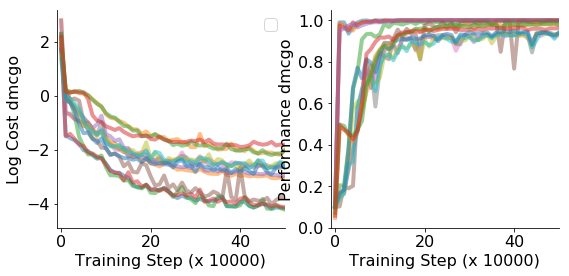

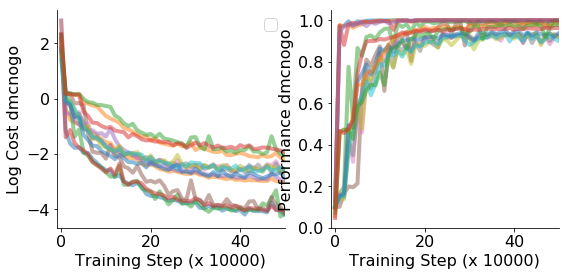

In [3]:
# parse input arguments as:
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
n_rnn = int(256)
l2w = float(-6)
l2h = float(-6)
l1w = float(0)
l1h = float(0)
lr = float(-7)
seed = str(0)

rule_trains_all = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
              'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
              'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

for pop_rule in range(len(rule_trains_all)):
    fig = plt.figure(figsize=(9, 4))
    plt.rcParams.update({'font.size': 16})
    task_list = ['fdgo',]
    ax_cost = plt.subplot(121)
    ax_perf = plt.subplot(122)

    rule_trains_pre = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti',
    'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm',
    'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']

    rule_trains_pre.pop(pop_rule)

    post_train = rule_trains_all[pop_rule]

    s = '_'
    rule_trains_str = s.join(rule_trains_pre)
    
    m = os.path.join(p,'data','rnn','multitask',net,'lr',rnn_type,activation,init,str(len(rule_trains_pre))+'_tasks',
        str(n_rnn)+'_n_rnn','lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str,seed)

#     m = os.path.join(p,'code','multitask-nets',net,'data',rnn_type,activation,init,str(len(rule_trains_pre))+'_tasks',
#         str(n_rnn)+'_n_rnn','lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str,seed)

    fname = os.path.join(m, 'log.json')

    with open(fname, 'r') as f:
        log_all = json.load(f)
    for r in range(len(rule_trains_pre)):

        plt.sca(ax_cost)
        x = np.log(log_all['cost_'+rule_trains_pre[r]])
        plt.plot(x,'-',alpha = .5,linewidth = 4)
        ax_cost.set_xlabel('Training Step (x 10000)')
        ax_cost.set_ylabel('Log Cost '+post_train)
        plt.xlim([-1,50]) 
#         plt.ylim([-3.2,3]) 

        plt.sca(ax_perf)
        x = log_all['perf_'+rule_trains_pre[r]]
        plt.plot(x,'-',alpha = .5,linewidth = 4)
        ax_perf.set_xlabel('Training Step (x 10000)')
        ax_perf.set_ylabel('Performance '+post_train)
        plt.xlim([-1,50]) 
#         plt.ylim([-.05,1]) 


    ax_perf.spines['top'].set_visible(False)
    ax_perf.spines['right'].set_visible(False)

    ax_cost.spines['top'].set_visible(False)
    ax_cost.spines['right'].set_visible(False)
    plt.sca(ax_cost)
    plt.legend()

In [4]:
model_params = np.load(os.path.join(m ,'model_params.npz'))

In [5]:
model_params.keys()

['b_out', 'w_out', 'b_in', 'w_in']

In [6]:
np.shape(model_params['w_in'])

(281, 256)

In [7]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo/0/model

In [24]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('fdgo', hparams, mode='random', noise_on=False, batch_size = 128*16)

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delayanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo/0/model.ckpt


In [30]:
type(float(hparams['n_input']))

float

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_dmcgo/0/model.ckpt


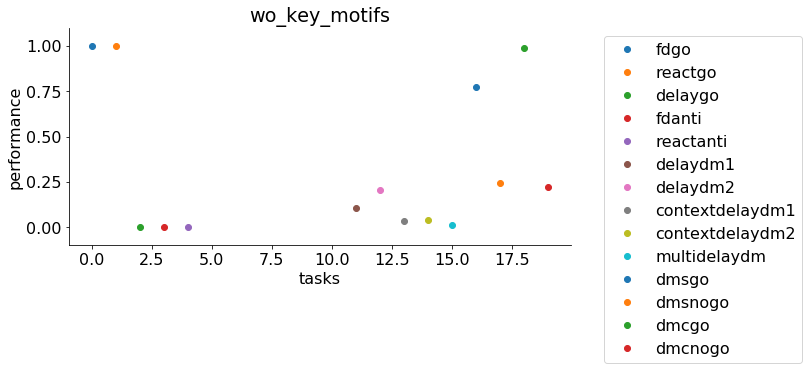

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt


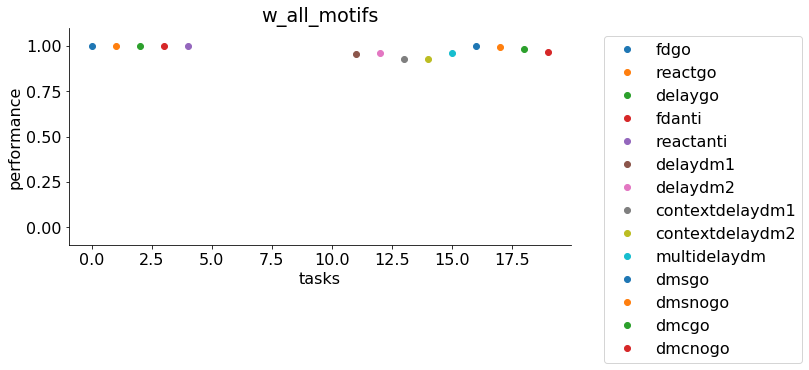

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/model.ckpt


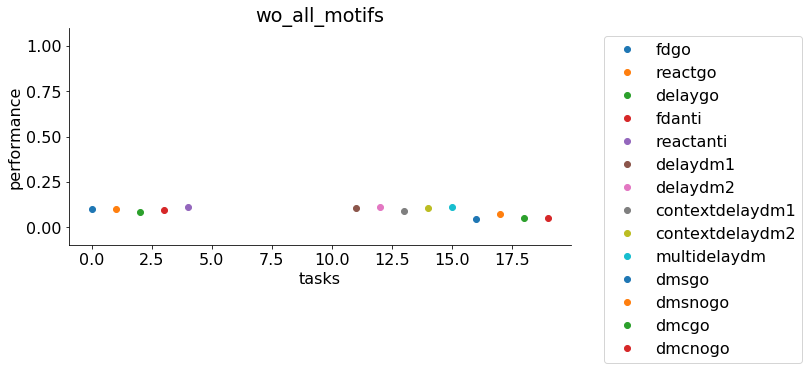

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt


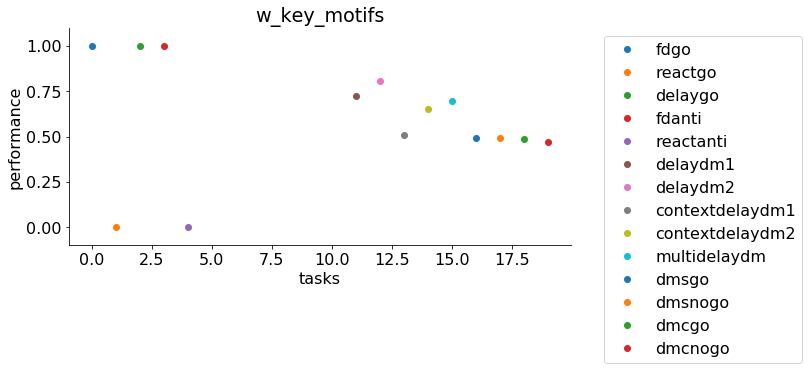

In [3]:
data_folder = os.path.join('data/rnn/multitask/',net,'variable_stim_slow_learn_big_noise')
data_folder = os.path.join('data/rnn/multitask/',net,'lr')
rnn_type = 'LeakyRNN'
activation = 'softplus'
init = 'randgauss'
seed = '0'
n_rnn = str(256)
l2w = -6
l2h = -6
l1w = 0
l1h = 0
lr = -7

rule_trains_set = {}
rule_trains_set['w_all_motifs'] = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti','delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm','dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']
rule_trains_set['w_key_motifs'] = ['fdgo', 'delaygo', 'fdanti']
rule_trains_set['wo_key_motifs'] = ['fdgo', 'reactgo', 'dmcgo']
rule_trains_set['wo_all_motifs'] = []

for rule_trains_label in rule_trains_set:
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    transfer_m = os.path.join(data_folder,rnn_type,activation,init,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,transfer_m)
    
    fig = plt.figure(figsize=(9, 4))
    plt.rcParams.update({'font.size': 16})
    ax = plt.subplot(111)
    
    model = Model(m)
    with tf.Session() as sess:
        model.restore()
        var_list = model.var_list
        params = [sess.run(var) for var in var_list]
        hparams = model.hp
        for rule in rule_trains_set['w_all_motifs']:#hparams['rule_trains']:
            trial = generate_trials(rule, hparams, mode='random', noise_on=False, batch_size = 128*16)
            feed_dict = tools.gen_feed_dict(model, trial, hparams)
            h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
            perf = get_perf(y_hat_tf,trial.y_loc)
            plt.plot(np.where(trial.x[0,0,5:]), np.mean(perf),'o',label = rule)
#             plt.text(np.where(trial.x[0,0,5:]), np.mean(perf),rule,rotation = 45)
            
    plt.title(rule_trains_label)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.ylim((-0.1,1.1))
    plt.xlabel('tasks')
    plt.ylabel('performance')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
      
    plt.show()

In [4]:
rule_trains_set

{'w_all_motifs': ['fdgo',
  'reactgo',
  'delaygo',
  'fdanti',
  'reactanti',
  'delaydm1',
  'delaydm2',
  'contextdelaydm1',
  'contextdelaydm2',
  'multidelaydm',
  'dmsgo',
  'dmsnogo',
  'dmcgo',
  'dmcnogo'],
 'w_key_motifs': ['fdgo', 'delaygo', 'fdanti'],
 'wo_all_motifs': [],
 'wo_key_motifs': ['fdgo', 'reactgo', 'dmcgo']}

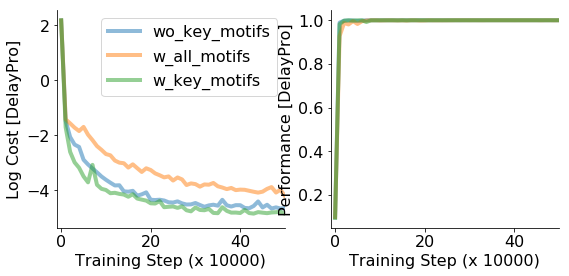

In [5]:
fig = plt.figure(figsize=(9, 4))
plt.rcParams.update({'font.size': 16})
task_list = ['fdgo',]
ax_cost = plt.subplot(121)
ax_perf = plt.subplot(122)

for rule_trains_label in rule_trains_set:
    if rule_trains_label is not 'wo_all_motifs':
        rule_trains = rule_trains_set[rule_trains_label]

        s = '_'
        rule_trains_str = s.join(rule_trains)

        net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
        net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str

        pretrain_m = os.path.join(data_folder,rnn_type,activation,init,
                                  str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)

        m = os.path.join(p,pretrain_m)

        fname = os.path.join(m, 'log.json')

        with open(fname, 'r') as f:
            log_all = json.load(f)
        for r in range(len(task_list)):

            plt.sca(ax_cost)
            x = np.log(log_all['cost_'+task_list[r]])
            plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
            ax_cost.set_xlabel('Training Step (x 10000)')
            ax_cost.set_ylabel('Log Cost [DelayPro]')
            plt.xlim([-1,50]) 
    #         plt.ylim([-3.2,3]) 

            plt.sca(ax_perf)
            x = log_all['perf_'+task_list[r]]
            plt.plot(x,'-',alpha = .5,linewidth = 4,label = rule_trains_label)
            ax_perf.set_xlabel('Training Step (x 10000)')
            ax_perf.set_ylabel('Performance [DelayPro]')
            plt.xlim([-1,50]) 
    #         plt.ylim([-.05,1]) 


ax_perf.spines['top'].set_visible(False)
ax_perf.spines['right'].set_visible(False)

ax_cost.spines['top'].set_visible(False)
ax_cost.spines['right'].set_visible(False)
plt.sca(ax_cost)
plt.legend()

In [6]:
from collections import OrderedDict
def make_h_all(m,mode = 'test',rules = []):
    model = Model(m, sigma_rec=0)
    with tf.Session() as sess:
        model.restore()

        h_all_byrule = OrderedDict()
        h_all_byepoch = OrderedDict()

        hp = model.hp
        n_hidden = hp['n_rnn']
        
        if len(rules)==0:
            rules = hp['rules']

        for rule in rules:
            trial = generate_trials(rule, hp, mode = mode, noise_on=False, batch_size = 100)
            feed_dict = tools.gen_feed_dict(model, trial, hp)
            h = sess.run(model.h, feed_dict=feed_dict)

            for e_name, e_time in trial.epochs.items():
                # if 'fix' not in e_name:  # Ignore fixation period
                h_all_byepoch[(rule, e_name)] = h[e_time[0]:e_time[1],:,:]
                
            h_all_byrule[rule] = h
                
    return h_all_byepoch, h_all_byrule


def make_pcs_taskset(m,taskset):
    _, h_all_byrule = make_h_all(m,mode = 'test',rules = taskset)
    N = np.shape(h_all_byrule[taskset[0]])[2]

    X_use = np.reshape(h_all_byrule[taskset[0]][:],(-1,N))
    for rule in taskset[1:]:
        X_rule = h_all_byrule[rule]
        X_use = np.concatenate((X_use,np.reshape(X_rule[:],(-1,N))),axis = 0)

    from sklearn.decomposition import PCA
    pca = PCA(n_components = 20)
    h_all_pca = pca.fit_transform(X_use)
    return pca

In [7]:
def make_D(m,task_set):

    h, trial, _ = make_h_trial_rule(m,task_set = task_set)
    _, _, w_out, _  = get_model_params(m)
    pca = make_pcs_taskset(m,task_set)

    ind = -1
    stim_angle = []
    target_angle = []
    r = []

    for ri in range(len(task_set)):
        rule = task_set[ri]
        T_inds = get_T_inds(trial[rule],'stim1')
        T_use = T_inds[ind]
        inds_use = np.min(trial[rule].stim_strength,axis=1)>.5
        r_temp = h[rule][T_use,inds_use,:].T
        stim1_locs = np.min(trial[rule].stim_locs[:,[0,2]],axis=1)
        stim_angle_temp = stim1_locs[inds_use]
        target_angle_temp = trial[rule].y_loc[-1,inds_use]

        if len(stim_angle)==0:
            stim_angle = stim_angle_temp
            target_angle = target_angle_temp
            r = r_temp
        else: 
            stim_angle = np.concatenate((stim_angle,stim_angle_temp))
            target_angle = np.concatenate((target_angle,target_angle_temp))
            r = np.concatenate((r,r_temp),axis = 1)

    y1 = np.expand_dims(np.sin(stim_angle),axis = 1)
    y2 = np.expand_dims(np.cos(stim_angle),axis = 1)
    stim_y = np.concatenate((y1,y2),axis=1)

    lm = linear_model.LinearRegression()
    model = lm.fit(stim_y,r.T)
    Beta = model.coef_
    B_stim,_ = LA.qr(Beta)

    y1 = np.expand_dims(np.sin(target_angle),axis = 1)
    y2 = np.expand_dims(np.cos(target_angle),axis = 1)
    target_y = np.concatenate((y1,y2),axis=1)

    lm = linear_model.LinearRegression()
    model = lm.fit(target_y,r.T)
    Beta = model.coef_
    B_target,_ = LA.qr(Beta)       
    
    return pca,w_out,B_stim,B_target

In [8]:
def plot_N3D(ax, X, D, clist, linewidth = 1, alpha = .5, linestyle = '-',markersize = 10):
    """Plot activity is some 2D space.

        Args:
            X: neural activity in Trials x Time x Neurons
            D: Neurons x 2 plotting dims
        """

    cmap=plt.get_cmap('rainbow')
    S = np.shape(X)[0]
    
    for s in range(S):

        if isinstance(clist, str) :
            c = clist
        else:
            c = cmap(clist[s]/max(clist))

        X_trial = np.dot(X[s,:,:],D.T)
        ax.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyle,c = c, linewidth = linewidth, alpha = alpha)
        ax.scatter(X_trial[0,0],X_trial[0,1],X_trial[0,2],s = markersize,c = 'k',marker = 'x',)
        ax.scatter(X_trial[-1,0],X_trial[-1,1],X_trial[-1,2],s = markersize,c = 'k',marker = '^')

Overwrite sigma_rec with 0.000
0.0
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/model.ckpt
0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss

0.158113883008419
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/14_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_reactgo_delaygo_fdanti_reactanti_delaydm1_delaydm2_contextdelaydm1_contextdelaydm2_multidelaydm_dmsgo_dmsnogo_dmcgo_dmcnogo/0/model.ckpt
Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variab

INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/3_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_fdgo_delaygo_fdanti/0/model.ckpt


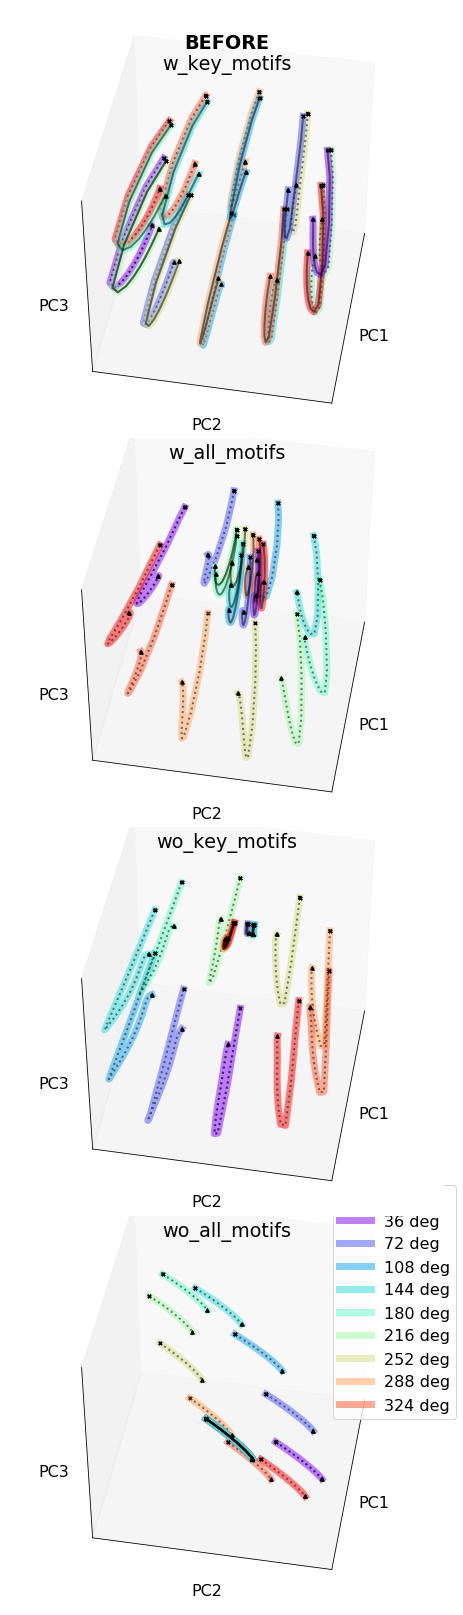

In [28]:
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size': 16})
task_set = ['fdgo',]

trial_set = range(0,80,8)
n_steps = -25
color_list = [.5,.5]
linestyles = [':','-']

fig = plt.figure(figsize=(6,3.6*6),tight_layout=True,facecolor='white')
keys = ['wo_all_motifs', 'wo_key_motifs', 'w_all_motifs', 'w_key_motifs']
    
for rti in range(len(keys)):
    rule_trains_label = keys[rti]
    
    ax_3D = fig.add_axes([0,rti*(1/len(keys)),1,1.1/len(keys)], projection='3d');
    
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    pretrain_m = os.path.join(data_folder,rnn_type,activation,init,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,pretrain_m)
    
    pca,w_out,B_stim,B_target = make_D(m,task_set)
    D_inds = {}
    D_inds[0] = pca.components_[:3,:]
    nr = 1
    nc = len(D_inds)

    axes_labels = {}
    axes_labels[0] = ['PC1','PC2','PC3']
    
    rules = ['fdgo','delayanti']
    _, h_all_byrule = make_h_all(m,mode = 'test',rules = rules)
    
    for ri in range(len(rules)):
        rule = rules[ri]
        trial = gen_trials_from_model_dir(m,rule,noise_on = False)
        X = np.transpose(h_all_byrule[rule][:,trial_set,:],(1, 0, 2))

        inds = {}
        inds['all'] = range(0,np.shape(X)[1])
        inds['stim'] = range(0,trial.epochs['go1'][0])
        inds['go'] = range(trial.epochs['go1'][0],np.shape(X)[1])
        
        for sp in range(len(D_inds)):
        
            D = D_inds[sp]
            X_subselect = X[:,inds['go'],:]
            clist = trial.y_loc[-1,trial_set]
            
            X_trial = np.dot(X_subselect[0,:,:],D.T)
            X_start = np.dot(X_subselect[:,0,:],D.T)
            X_end = np.dot(X_subselect[:,-1,:],D.T)
            ax_3D.plot3D(X_trial[:,0],X_trial[:,1],X_trial[:,2],linestyles[ri],c = 'k', linewidth = 2, 
                      alpha = .5,label = rule)
            ax_3D.scatter(X_start[:,0],X_start[:,1],X_start[:,2],s = 10,c = 'k',marker = 'x',
                       label = 'start')
            ax_3D.scatter(X_end[:,0],X_end[:,1],X_end[:,2],s = 10,c = 'k',marker = '^',
                       label = 'end')
        
            plot_N3D(ax_3D,X_subselect, D, clist,linestyle = '-',linewidth = 7,alpha = color_list[ri],markersize = 10)
            plot_N3D(ax_3D,X_subselect, D, 'k',linestyle = linestyles[ri],linewidth = 2,alpha = .5,markersize = 10)
            ax_3D.set_xlabel(axes_labels[sp][0])
            ax_3D.set_ylabel(axes_labels[sp][1])
            ax_3D.set_zlabel(axes_labels[sp][2])
            ax_3D.spines['top'].set_visible(False)
            ax_3D.spines['right'].set_visible(False)
            ax_3D.spines['bottom'].set_visible(False)
            ax_3D.spines['left'].set_visible(False)
            ax_3D.set_yticks([])
            ax_3D.set_xticks([])
            ax_3D.set_zticks([])
            plt.title(rule_trains_label)
#             plt.axis('square')
            ax_3D.view_init(45, 10)
            plt.tight_layout()
            if rti==0:
                plt.legend([str(int(360*x/80))+' deg' for x in trial_set],bbox_to_anchor=(1.05, 1))

plt.suptitle('BEFORE',fontweight='bold',y = 1.01)
fig_dir = os.path.join(figpath,'pretrain')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

figname = rule_trains_label
plt.savefig(os.path.join(fig_dir,figname+'.pdf'))
plt.savefig(os.path.join(fig_dir,figname+'.png'))
plt.show()


Overwrite sigma_rec with 0.000
0.0
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(281, 256) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(256, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/model.ckpt
['fdgo', 'delaygo', 'fdanti', 'delayanti']
Variance saved at /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss/0_tasks/256_n_rnn/lr7.0l2_w6.0_h6.0_/0/variance_rule.pkl
Variance saved at /Users/lauradriscoll/Documents/data/rnn/multitask/stepnet/lr/LeakyRNN/softplus/randgauss

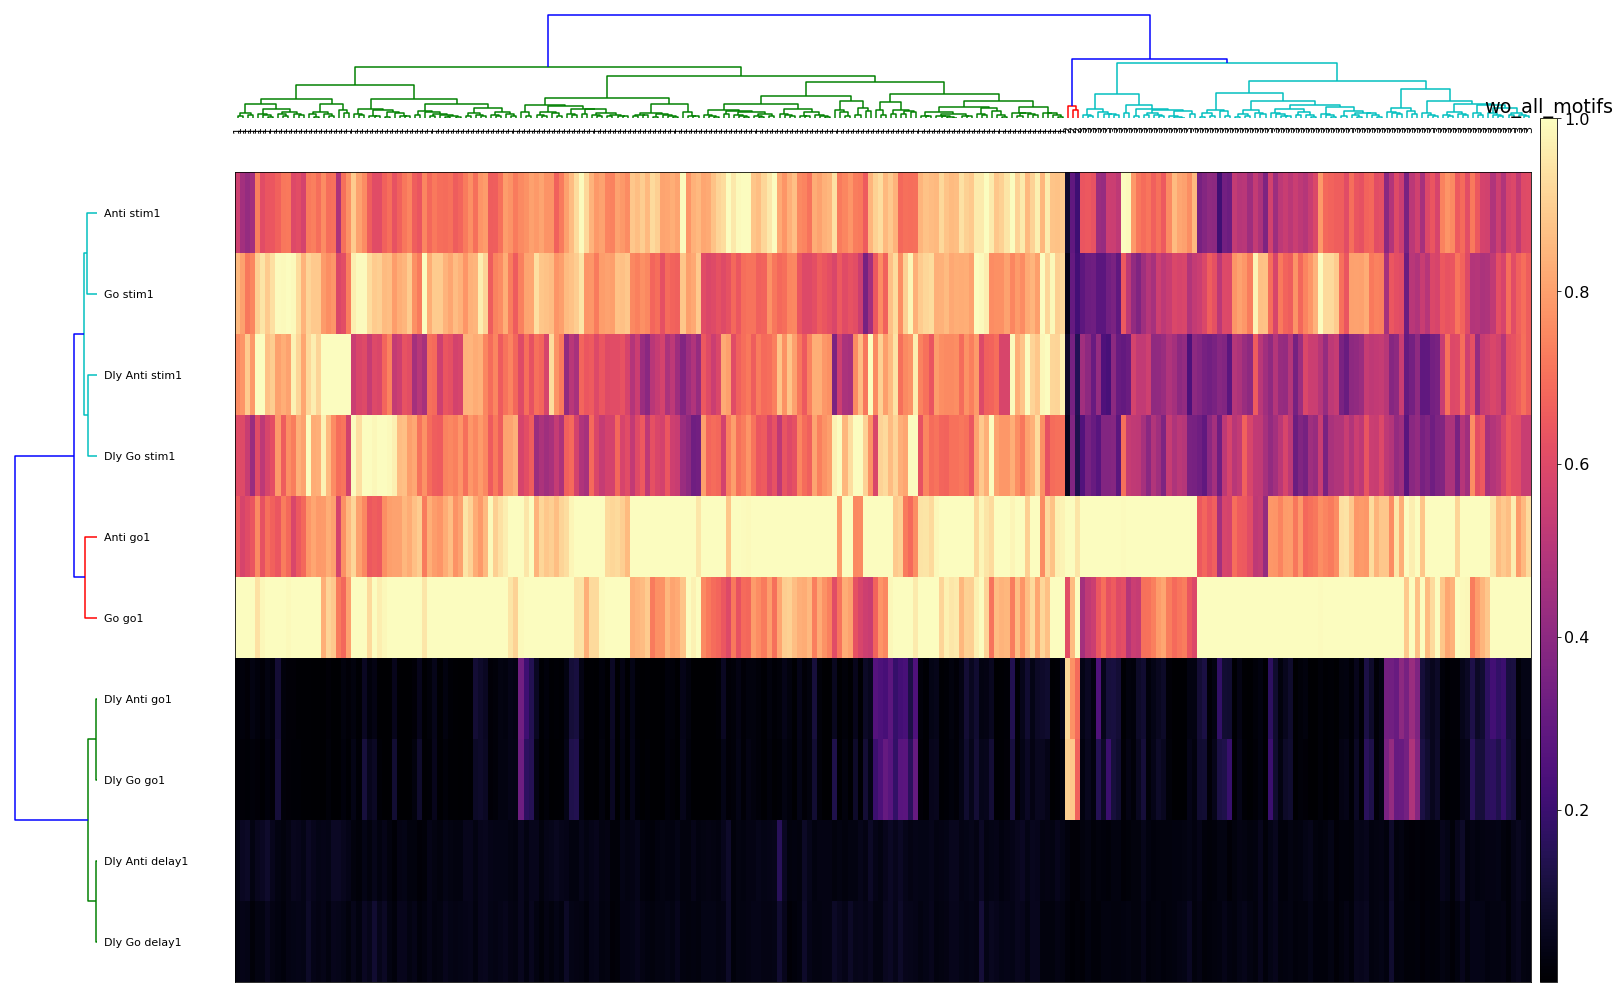

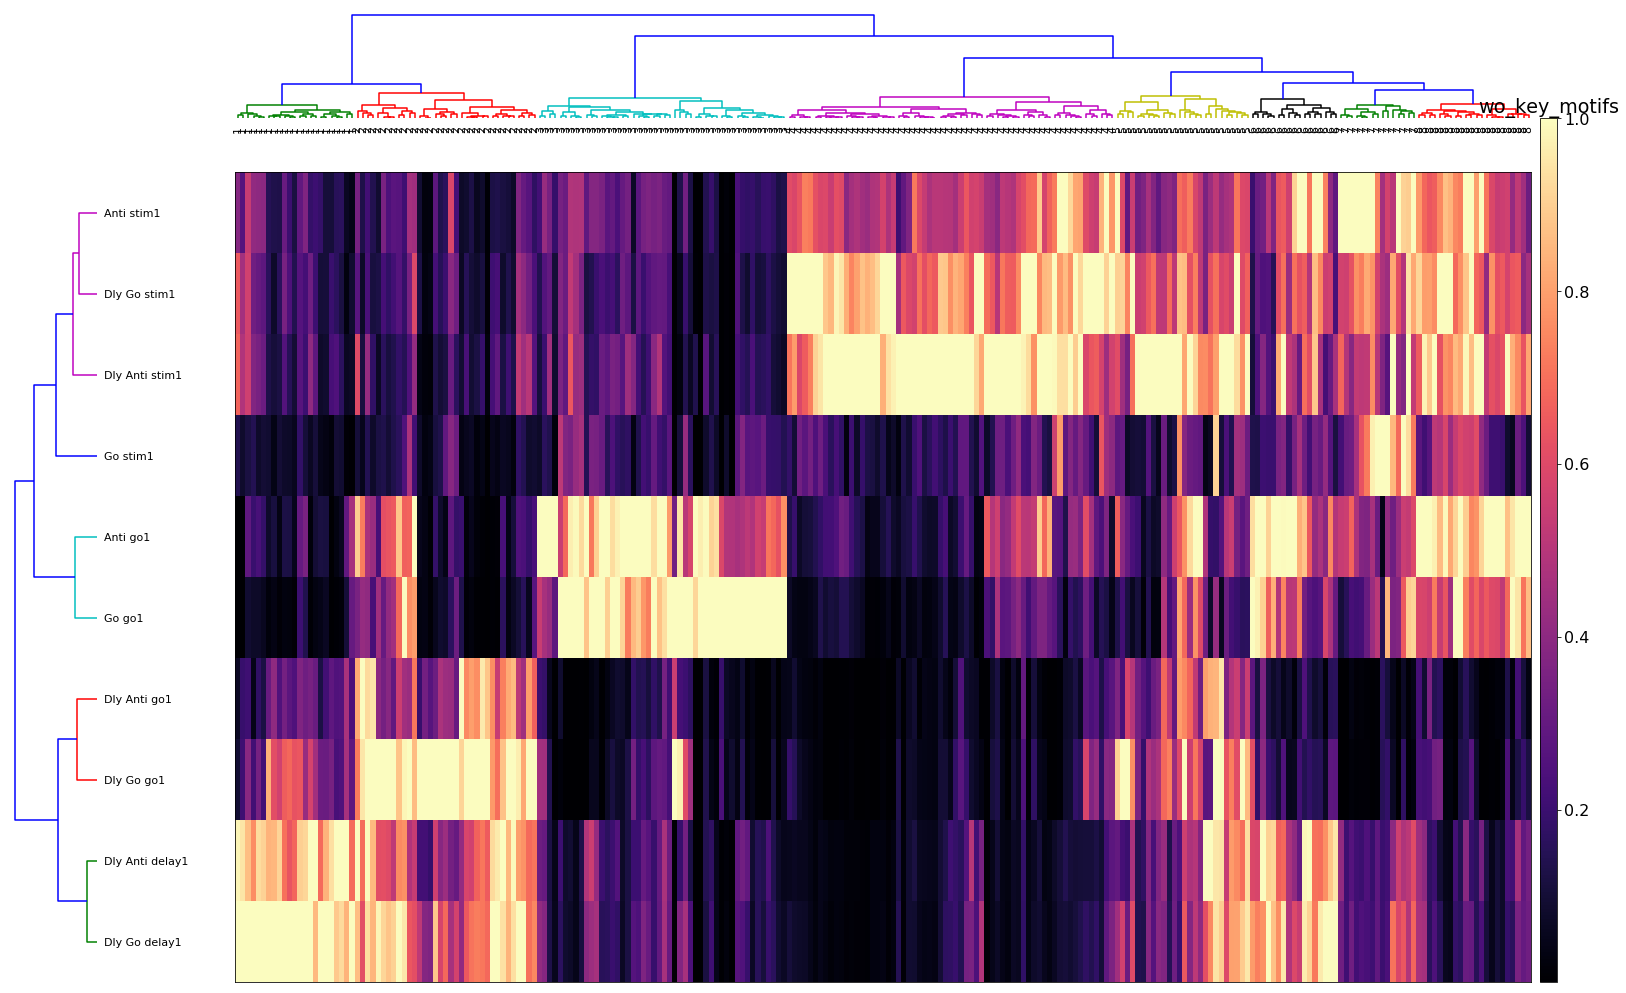

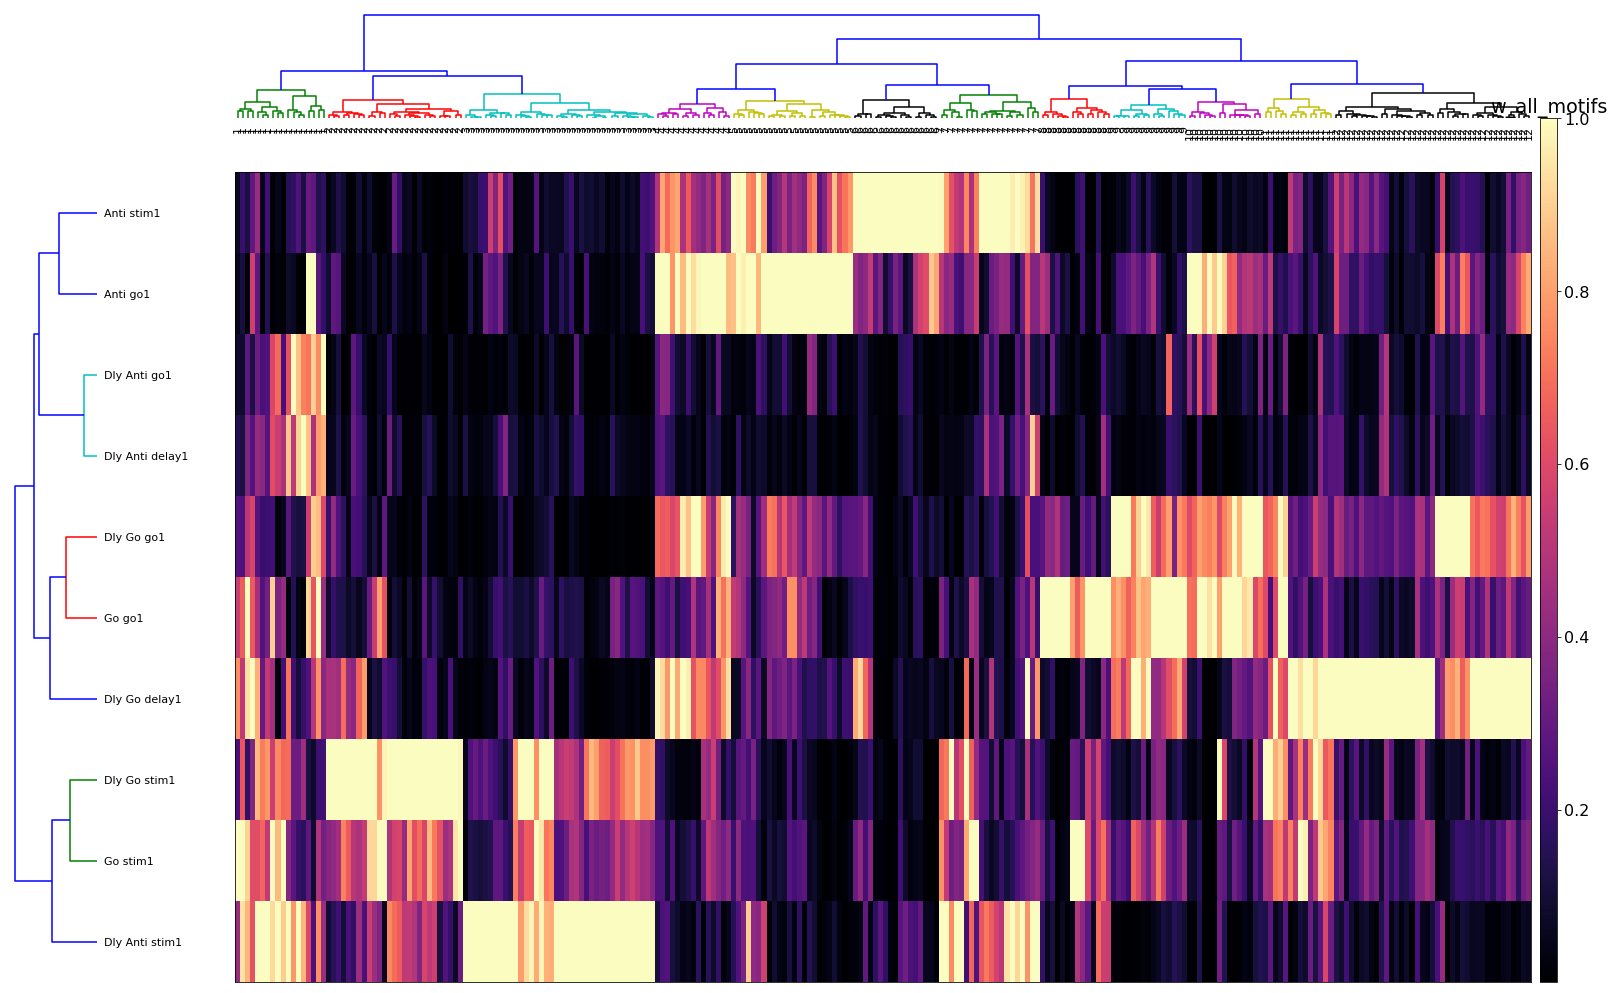

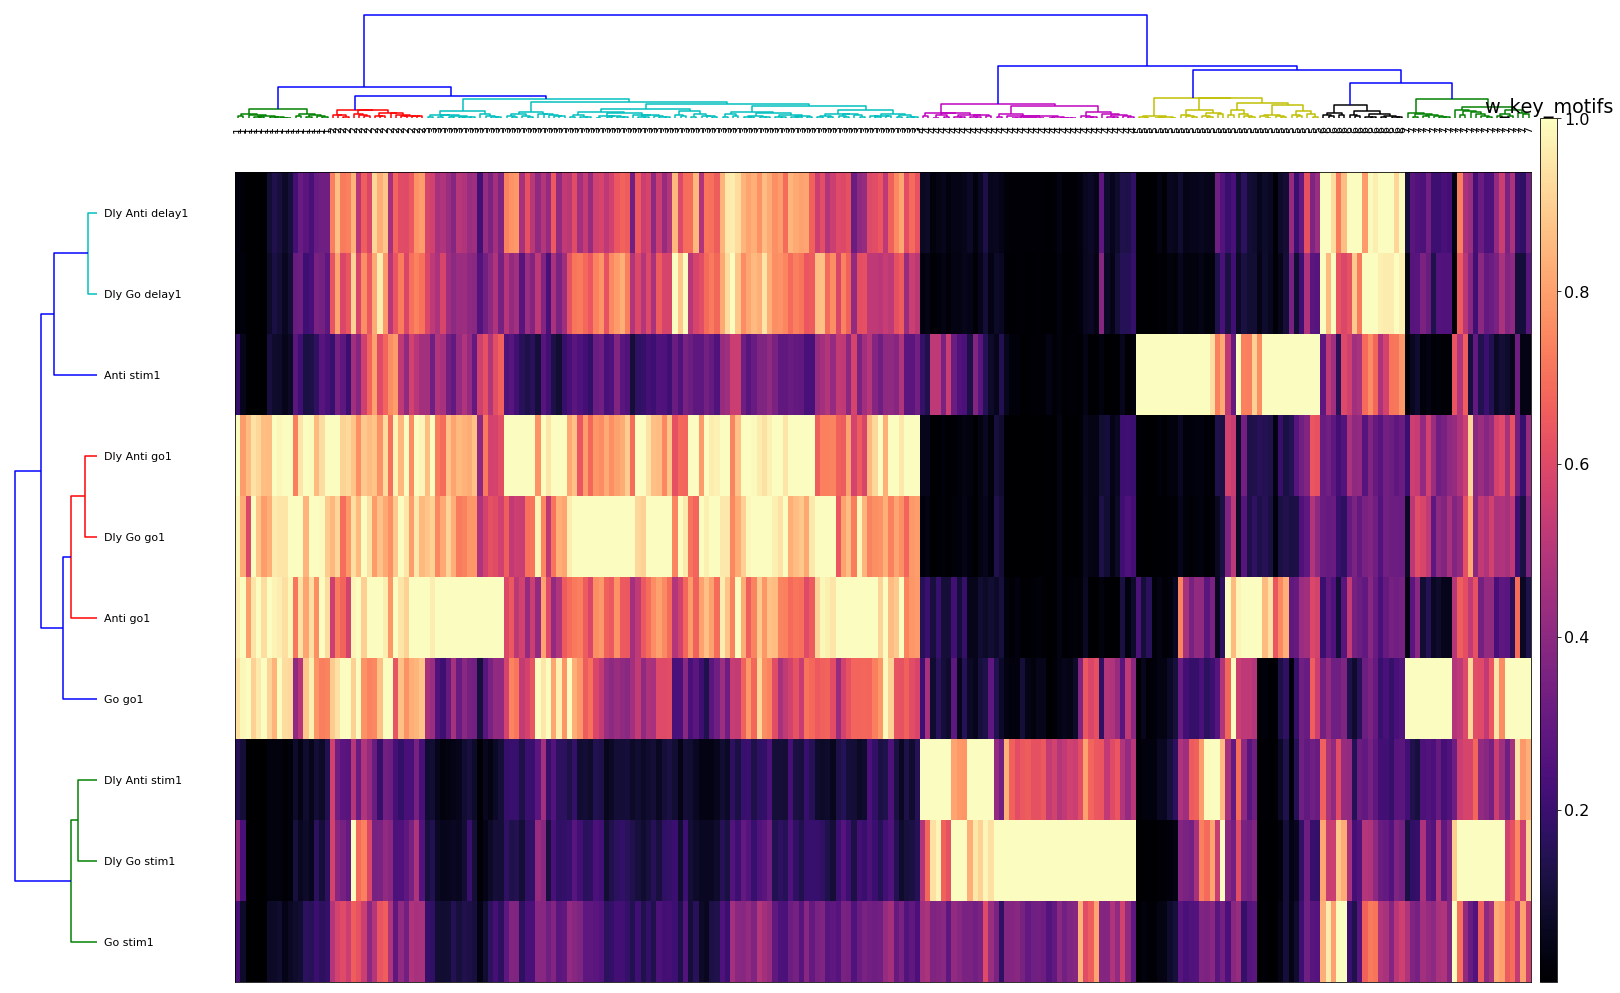

In [29]:
keys = ['wo_all_motifs', 'wo_key_motifs', 'w_all_motifs', 'w_key_motifs']
for rti in range(len(keys)):
    rule_trains_label = keys[rti]
    
    rule_trains = rule_trains_set[rule_trains_label]

    s = '_'
    rule_trains_str = s.join(rule_trains)

    net_name = 'lr'+"{:.1f}".format(-lr)+'l2_w'+"{:.1f}".format(-l2w)+'_h'+"{:.1f}".format(-l2h)+'_'+rule_trains_str
    
    pretrain_m = os.path.join(data_folder,rnn_type,activation,init,
                              str(len(rule_trains))+'_tasks',str(n_rnn)+'_n_rnn',net_name,seed)
    
    m = os.path.join(p,pretrain_m)
    variance.compute_variance(m,rules = ['fdgo','delaygo', 'fdanti', 'delayanti'])

#     plot_training(m)

    make_dendro(m)
    plt.title(rule_trains_label)